## Etapa 2: Modelación

En esta etapa se entrenarán **cuatro modelos de clasificación** con el objetivo de identificar cuál ofrece el mejor desempeño para nuestro conjunto de datos. 

El proceso se realizará reutilizando la **función de pipeline sin fuga de datos**, garantizando una comparación justa y controlada entre los modelos.  

De esta manera podremos evaluar tanto la **precisión predictiva** como la **capacidad de generalización** de cada enfoque, seleccionando el modelo más adecuado según los resultados obtenidos.


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

def train_pipeline(X_train, y_train, model, param_grid):
    """
    Entrena un modelo dentro de un pipeline con escalado (sin fuga de datos),
    usando validación cruzada y GridSearchCV.
    """
    pipe = Pipeline([
        ("scaler", MinMaxScaler()),
        ("clf", model)
    ])
    grid = GridSearchCV(pipe, param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid


In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score,recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from joblib import dump


X = all_data.drop("enfermedad_cardiaca", axis=1)
y = all_data["enfermedad_cardiaca"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)



modelos = {
    "LogisticRegression": (
        LogisticRegression(max_iter=500),
        {
            "clf__C": [0.01, 0.1, 1, 10],
            "clf__penalty": ["l2"],
            "clf__solver": ["lbfgs"]
        }
    ),
    "RandomForestClassifier": (
        RandomForestClassifier(random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [4, 6, 8],
            "clf__min_samples_split": [2, 5]
        }
    ),
    "KNeighborsClassifier": (
        KNeighborsClassifier(),
        {
            "clf__n_neighbors": [3, 5, 7],
            "clf__weights": ["uniform", "distance"]
        }
    ),
    "GradientBoostingClassifier": (
        GradientBoostingClassifier(random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__learning_rate": [0.05, 0.1],
            "clf__max_depth": [3, 5]
        }
    )
}


resultados = []

for nombre, (modelo, grid) in modelos.items():

    grid_model = train_pipeline(X_train, y_train, modelo, grid)
    
    y_pred = grid_model.predict(X_test)
    y_prob = grid_model.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)  
    
    resultados.append({
        "Modelo": nombre,
        "AUC": auc,
        "F1": f1,
        "Accuracy": acc,
        "Recall": recall,   
    })


df_resultados = pd.DataFrame(resultados).sort_values(by="AUC", ascending=False)
print("\n========== RESULTADOS COMPARATIVOS ==========")
print(df_resultados)
print("============================================")






========== RESULTADOS COMPARATIVOS ==========
                       Modelo       AUC        F1  Accuracy   Recall
1      RandomForestClassifier  0.949353  0.885246  0.885246  0.84375
2        KNeighborsClassifier  0.943966  0.857143  0.852459  0.84375
0          LogisticRegression  0.943966  0.892308  0.885246  0.90625
3  GradientBoostingClassifier  0.937500  0.870968  0.868852  0.84375


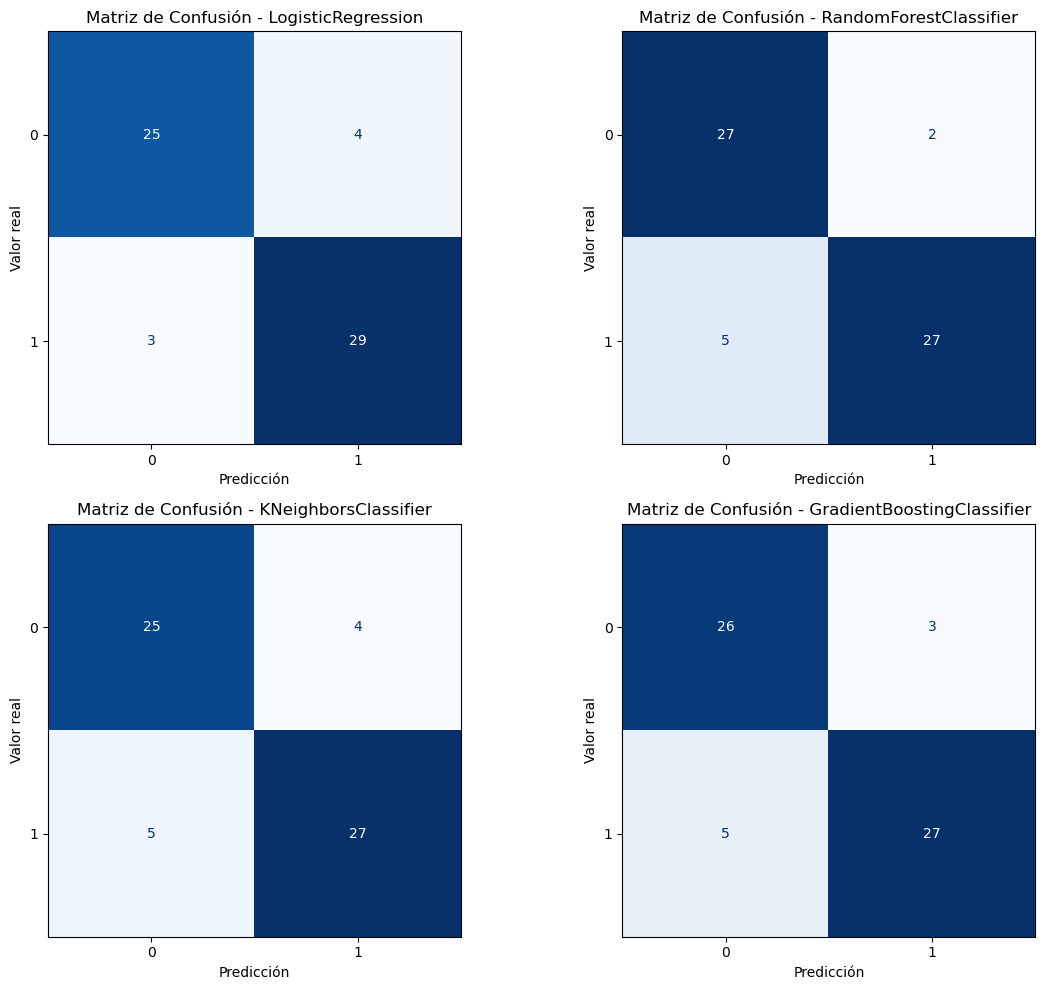

In [ ]:


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Entrenar cada modelo y graficar su matriz de confusión
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()  # para indexar fácilmente

for i, (nombre, (modelo, grid)) in enumerate(modelos.items()):
    
    grid_model = train_pipeline(X_train, y_train, modelo, grid)
    y_pred = grid_model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i], cmap="Blues", colorbar=False)
    axes[i].set_title(f"Matriz de Confusión - {nombre}")
    axes[i].set_xlabel("Predicción")
    axes[i].set_ylabel("Valor real")

plt.tight_layout()
plt.show()


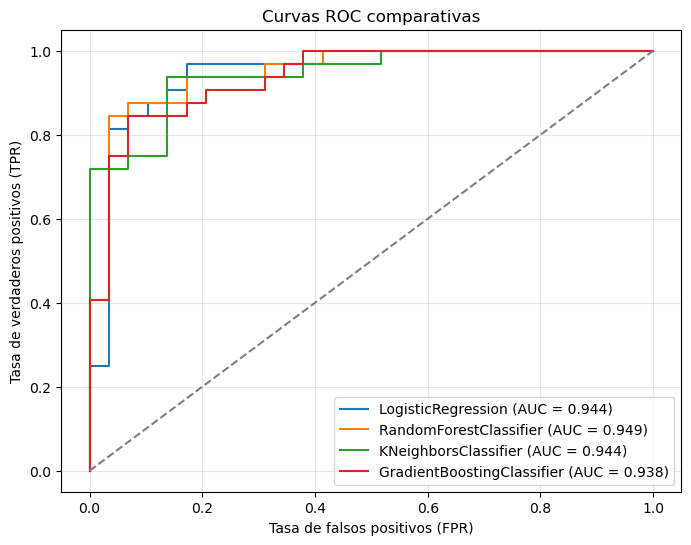

In [ ]:


from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(8, 6))

for nombre, (modelo, grid) in modelos.items():
   
    grid_model = train_pipeline(X_train, y_train, modelo, grid)
    y_prob = grid_model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{nombre} (AUC = {auc:.3f})")

# Línea base
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.title("Curvas ROC comparativas")
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


Todas las curvas están muy por encima de la diagonal base, lo que confirma que los modelos tienen excelente capacidad discriminativa entre pacientes enfermos y sanos.
Ninguno está cerca del azar (línea gris diagonal), lo que demuestra que el aprendizaje fue efectivo.

El Random Forest tiene la curva más pegada al eje superior izquierdo, indicando que mantiene una tasa alta de verdaderos positivos con pocos falsos positivos.
Eso explica su AUC más alto (0.949) y su rendimiento estable.

La Regresión Logística y el KNN muestran curvas muy similares, también con alto desempeño (AUC > 0.94),
lo que refuerza la idea de que el dataset es altamente predictivo y bien balanceado.

Gradient Boosting se mantiene competitivo, pero con una ligera caída en la zona media de la curva, lo que sugiere que puede necesitar más árboles o ajuste del learning rate.

## Conclusión 
En general, todos los modelos evaluados mostraron un rendimiento sobresaliente, con valores de AUC y F1 muy similares y altos, lo que indica una excelente capacidad para distinguir entre pacientes con y sin enfermedad cardíaca.

El Random Forest fue el modelo con mayor precisión global (AUC ≈ 0.95), lo que lo posiciona como el más robusto en términos de predicción general. Sin embargo, en contextos médicos, donde identificar correctamente a los pacientes enfermos (verdaderos positivos) es más relevante que la precisión global, el modelo de Logistic Regression se vuelve la opción más adecuada, tal como lo pudimos observar en nuestra matriz de confusión en donde el modelo de Logistic Regression predijo 29 verdaderos positivos frente a apenas 3 falsos negativos, a comparación de Random Forest en donde se predijo 27 verdaderos positivos frente a 5 falsos negativos.

Esto explicaría porque Logistic Regression obtuvo el mayor Recall (≈ 0.91), lo que significa que detecta mejor a los pacientes con enfermedad real, reduciendo los falsos negativos —un error crítico en el ámbito clínico. Además, su naturaleza estadística la hace más interpretable, permitiendo identificar qué variables influyen más en la probabilidad de presentar la enfermedad.

> **Síntesis:**  
> Aunque el **Random Forest** fue el más preciso, **Logistic Regression** es la elección más apropiada para este contexto.

In [22]:

from joblib import dump

# Entrenar nuevamente con todos los datos para obtener el modelo definitivo
modelo_final = LogisticRegression(max_iter=500)
param_grid_final = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs"]
}

# Entrenamos con todo el dataset limpio usando el pipeline
best_grid = train_pipeline(X, y, modelo_final, param_grid_final)

# Crear la carpeta si no existe
import os
os.makedirs("models", exist_ok=True)

# Guardar el modelo
dump(best_grid.best_estimator_, "models/logistic_regression_final.joblib")

print(" Modelo final (Regresión Logística) guardado en: models/logistic_regression_final.joblib")


 Modelo final (Regresión Logística) guardado en: models/logistic_regression_final.joblib
